Enter the stock ticker (e.g. TCS.NS, AAPL):  AAPL


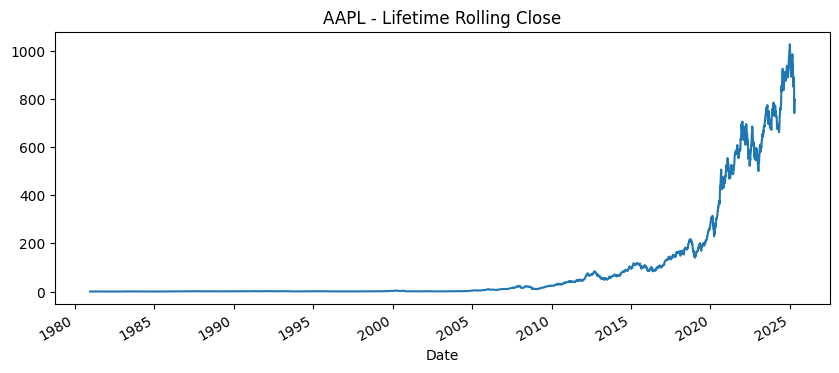

Enter START date for visualization (YYYY-MM-DD, after 2025):  2025-01-01
Enter END date for visualization (YYYY-MM-DD):  2025-04-01


70/70 [==============================] - 0s 2ms/step
Anomaly Threshold: 0.09288887464980859
1/1 [==============================] - 0s 44ms/step
⚠️ No anomalies detected. Showing sample reconstructions...



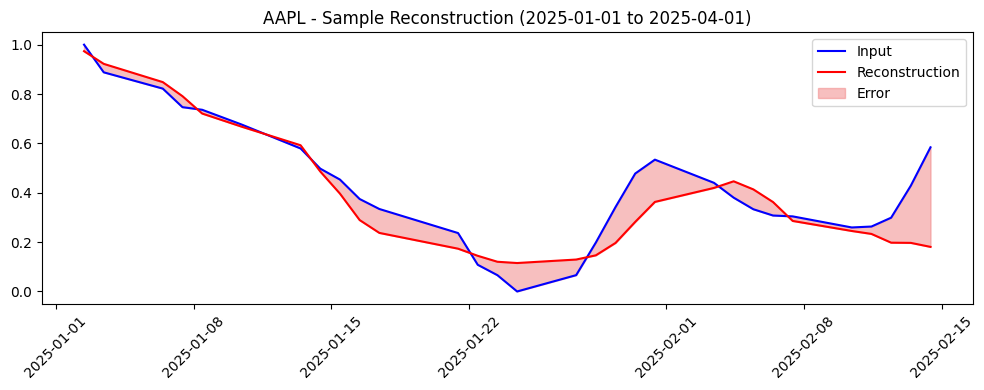

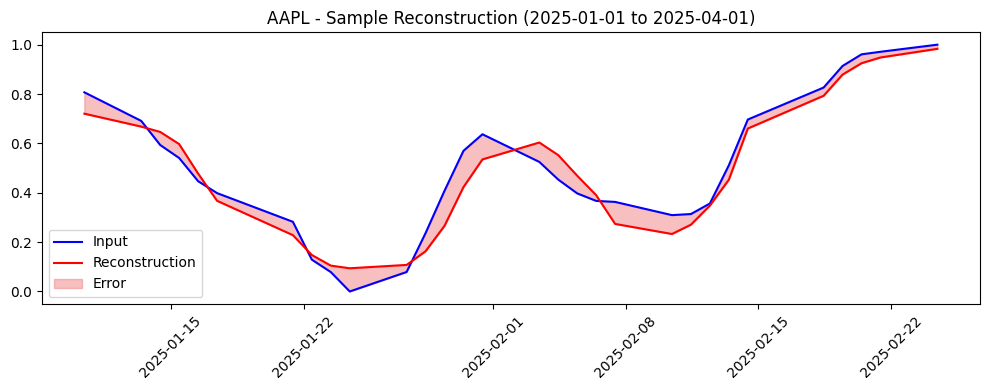

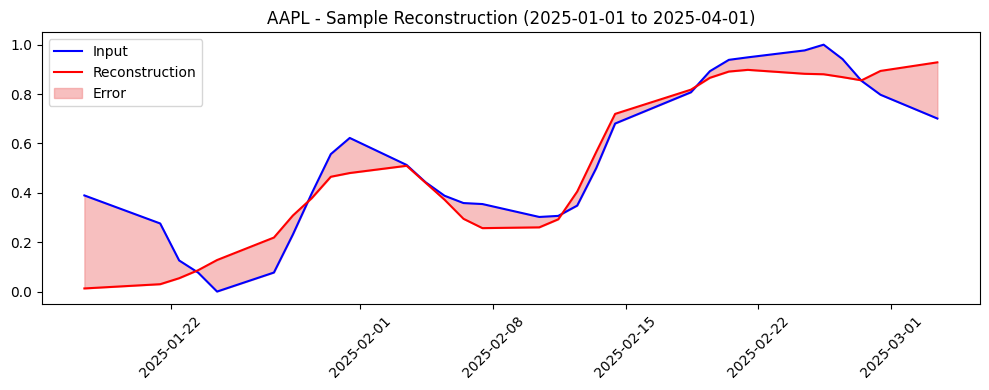

In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Model


# 🧠 Define Autoencoder
# ───────────────────────────────────────────────────────────────────────────────
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(30, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# ───────────────────────────────────────────────────────────────────────────────
# 📊 User Input and Data Preparation
# ───────────────────────────────────────────────────────────────────────────────
ticker = input("Enter the stock ticker (e.g. TCS.NS, AAPL): ").strip()
stock = yf.Ticker(ticker).history(period="max")['Close'].dropna()

# Convert index to datetime in IST
stock.index = pd.to_datetime(stock.index)
# Check if the index is already tz-aware
if stock.index.tz is None:
    stock.index = stock.index.tz_localize('UTC').tz_convert('Asia/Kolkata')
else:
    # If already tz-aware, just convert
    stock.index = stock.index.tz_convert('Asia/Kolkata')

# Smooth data
stock = stock.rolling(4).sum().dropna()

# Show full stock chart
plt.figure(figsize=(10, 4))
stock.plot(title=f"{ticker} - Lifetime Rolling Close")
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 📈 Split Data by Date
# ───────────────────────────────────────────────────────────────────────────────
window_size = 30
step = 5
scaler = MinMaxScaler()

train_data = stock[stock.index < pd.Timestamp('2025-01-01', tz='Asia/Kolkata')]
test_data = stock[stock.index >= pd.Timestamp('2025-01-01', tz='Asia/Kolkata')]

# ───────────────────────────────────────────────────────────────────────────────
# 🔧 Normalize Rolling Windows
# ───────────────────────────────────────────────────────────────────────────────
def normalize_window_roll(data, window_size, step=5):
    X, dates = [], []
    values = np.array(data)
    timestamps = data.index

    for i in range(0, len(values) - window_size, step):
        x_window = values[i:i+window_size]
        x_scaled = scaler.fit_transform(x_window.reshape(-1, 1))
        X.append(x_scaled)
        dates.append(timestamps[i:i+window_size])
    return np.squeeze(np.array(X), axis=2), dates

X_train, _ = normalize_window_roll(train_data, window_size, step)
X_test, date_windows = normalize_window_roll(test_data, window_size, step)

start_date = pd.to_datetime(input("Enter START date for visualization (YYYY-MM-DD, after 2025): ")).tz_localize('Asia/Kolkata')
end_date = pd.to_datetime(input("Enter END date for visualization (YYYY-MM-DD): ")).tz_localize('Asia/Kolkata')
# ───────────────────────────────────────────────────────────────────────────────
# 🧠 Train Autoencoder
# ───────────────────────────────────────────────────────────────────────────────
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_train, X_train),
    callbacks=[early_stopping],
    verbose=0
)

# ───────────────────────────────────────────────────────────────────────────────
# 🎯 Anomaly Detection
# ───────────────────────────────────────────────────────────────────────────────
reconstructions_train = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions_train, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Anomaly Threshold:", threshold)

reconstructions_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions_test, X_test)
anomalies = tf.math.greater(test_loss, threshold)
anomalous_test_data = X_test[np.where(anomalies)]
decoded = reconstructions_test

# ───────────────────────────────────────────────────────────────────────────────
# 📅 User Input for Custom Date Range (Post-2025)
# ───────────────────────────────────────────────────────────────────────────────


# Filter date windows based on user-defined date range
valid_indices = [
    i for i, window in enumerate(date_windows)
    if window[0] >= start_date and window[-1] <= end_date
]

# ───────────────────────────────────────────────────────────────────────────────
# 🖼️ Plotting based on user-defined date window
# ───────────────────────────────────────────────────────────────────────────────
tf.keras.backend.clear_session()
gc.collect()

if len(anomalous_test_data) == 0:
    print("⚠️ No anomalies detected. Showing sample reconstructions...\n")
    sample = X_test[:3]
    decoded_sample = autoencoder(sample).numpy()

    for i in range(len(sample)):
        if i >= len(valid_indices): break
        idx = valid_indices[i]
        plt.figure(figsize=(10, 4))
        plt.plot(date_windows[idx], sample[i], 'b')
        plt.plot(date_windows[idx], decoded_sample[i], 'r')
        plt.fill_between(date_windows[idx], decoded_sample[i], sample[i], color='lightcoral', alpha=0.5)
        plt.xticks(rotation=45)
        plt.legend(labels=["Input", "Reconstruction", "Error"])
        plt.title(f"{ticker} - Sample Reconstruction ({start_date.date()} to {end_date.date()})")
        plt.tight_layout()
        plt.show()
else:
    anomaly_indices = np.where(anomalies)[0]
    plots_shown = 0
    for i in range(len(anomaly_indices)):
        idx = anomaly_indices[i]
        if idx >= len(date_windows) or idx not in valid_indices: continue
        plt.figure(figsize=(10, 4))
        plt.plot(date_windows[idx], anomalous_test_data[i], 'b')
        plt.plot(date_windows[idx], decoded[idx], 'r')
        plt.fill_between(date_windows[idx], decoded[idx], anomalous_test_data[i], color='lightcoral', alpha=0.5)
        plt.xticks(rotation=45)
        plt.legend(labels=["Input", "Reconstruction", "Error"])
        plt.title(f"{ticker} - Anomaly Detected ({start_date.date()} to {end_date.date()})")
        plt.tight_layout()
        plt.show()
        plots_shown += 1
        if plots_shown >= 20: break

Enter the stock ticker (e.g. TCS.NS, AAPL):  ICICIBANK.NS


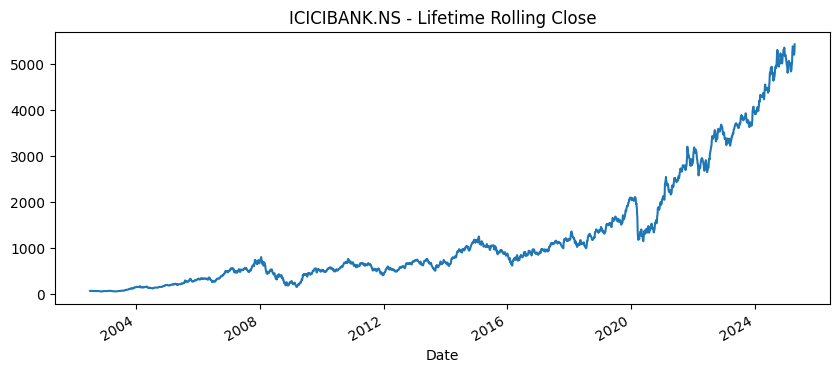

Enter START date for visualization (YYYY-MM-DD, after 2025):  2025-01-01
Enter END date for visualization (YYYY-MM-DD):  2025-04-01


35/35 [==============================] - 0s 4ms/step
Anomaly Threshold: 0.09534066040209163
1/1 [==============================] - 0s 40ms/step


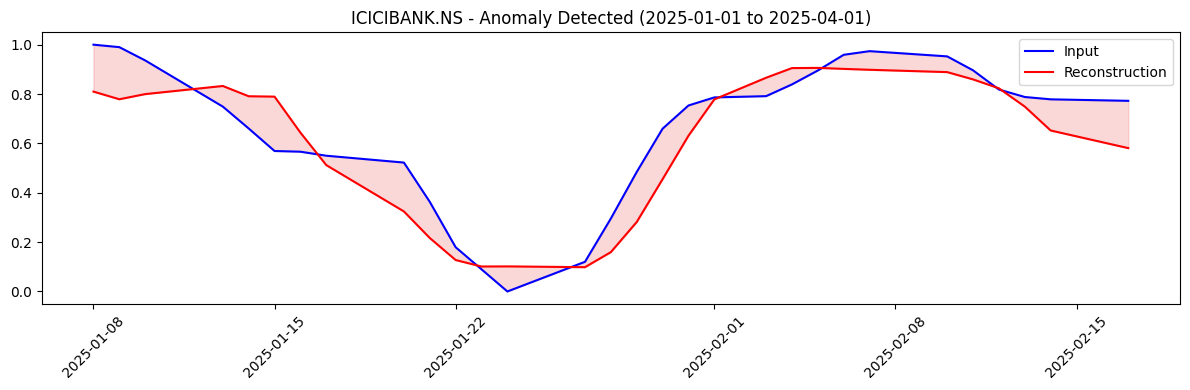

In [7]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# 🧠 Define Autoencoder
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(30, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 📊 User Input and Data Preparation
ticker = input("Enter the stock ticker (e.g. TCS.NS, AAPL): ").strip()
stock = yf.Ticker(ticker).history(period="max")['Close'].dropna()

# Convert index to datetime in IST
stock.index = pd.to_datetime(stock.index)
if stock.index.tz is None:
    stock.index = stock.index.tz_localize('UTC').tz_convert('Asia/Kolkata')
else:
    stock.index = stock.index.tz_convert('Asia/Kolkata')

# Smooth data
stock = stock.rolling(4).sum().dropna()

# Show full stock chart
plt.figure(figsize=(10, 4))
stock.plot(title=f"{ticker} - Lifetime Rolling Close")
plt.show()

# 📈 Split Data by Date
window_size = 30
step = 5
scaler = MinMaxScaler()

train_data = stock[stock.index < pd.Timestamp('2025-01-01', tz='Asia/Kolkata')]
test_data = stock[stock.index >= pd.Timestamp('2025-01-01', tz='Asia/Kolkata')]

# 🔧 Normalize Rolling Windows
def normalize_window_roll(data, window_size, step=5):
    X, dates = [], []
    values = np.array(data)
    timestamps = data.index

    for i in range(0, len(values) - window_size, step):
        x_window = values[i:i+window_size]
        x_scaled = scaler.fit_transform(x_window.reshape(-1, 1))
        X.append(x_scaled)
        dates.append(timestamps[i:i+window_size])
    return np.squeeze(np.array(X), axis=2), dates

X_train, _ = normalize_window_roll(train_data, window_size, step)
X_test, date_windows = normalize_window_roll(test_data, window_size, step)

start_date = pd.to_datetime(input("Enter START date for visualization (YYYY-MM-DD, after 2025): ")).tz_localize('Asia/Kolkata')
end_date = pd.to_datetime(input("Enter END date for visualization (YYYY-MM-DD): ")).tz_localize('Asia/Kolkata')

# 🧠 Train Autoencoder
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_train, X_train),
    callbacks=[early_stopping],
    verbose=0
)

# 🎯 Anomaly Detection
reconstructions_train = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions_train, X_train)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Anomaly Threshold:", threshold)

reconstructions_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions_test, X_test)
anomalies = tf.math.greater(test_loss, threshold).numpy()
anomaly_indices = np.where(anomalies)[0]

# 📅 User Input for Custom Date Range (Post-2025)
valid_indices = [
    i for i, window in enumerate(date_windows)
    if window[0] >= start_date and window[-1] <= end_date
]

# 🖼️ Plotting only ONE clean Input vs Reconstruction graph
tf.keras.backend.clear_session()
gc.collect()

if len(anomaly_indices) == 0:
    print("⚠️ No anomalies detected. Showing sample reconstruction...\n")
    idx = valid_indices[0] if valid_indices else 0
    sample = X_test[idx]
    decoded_sample = autoencoder(np.expand_dims(sample, axis=0)).numpy()[0]

    plt.figure(figsize=(12, 4))
    plt.plot(date_windows[idx], sample, 'b', label="Input")
    plt.plot(date_windows[idx], decoded_sample, 'r', label="Reconstruction")
    plt.fill_between(date_windows[idx], sample, decoded_sample, color='lightcoral', alpha=0.3)
    plt.title(f"{ticker} - Sample Reconstruction ({start_date.date()} to {end_date.date()})")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    first_valid_anomaly = next((i for i in anomaly_indices if i in valid_indices), None)
    if first_valid_anomaly is not None:
        input_window = X_test[first_valid_anomaly]
        reconstructed_window = reconstructions_test[first_valid_anomaly]
        window_dates = date_windows[first_valid_anomaly]

        plt.figure(figsize=(12, 4))
        plt.plot(window_dates, input_window, 'b', label="Input")
        plt.plot(window_dates, reconstructed_window, 'r', label="Reconstruction")
        plt.fill_between(window_dates, input_window, reconstructed_window, color='lightcoral', alpha=0.3)
        plt.title(f"{ticker} - Anomaly Detected ({start_date.date()} to {end_date.date()})")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Anomalies detected but none in selected date range.")
